<a href="https://colab.research.google.com/github/eldor-fozilov/ethereum-gas-price-prediction/blob/main/Average_gas_fee_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('average_gas.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df = df.set_index('timestamp')
df.head()

,average_gas_fee,avgGas
timestamp,,
2022-04-26 13:00:00,46.670,80868.519046
2022-04-26 14:00:00,78.150,85449.256791
2022-04-26 15:00:00,81.885,82192.413722
2022-04-26 16:00:00,67.235,82451.786800
2022-04-26 17:00:00,56.095,84236.446559


In [3]:
df.index

DatetimeIndex(['2022-04-26 13:00:00', '2022-04-26 14:00:00',
               '2022-04-26 15:00:00', '2022-04-26 16:00:00',
               '2022-04-26 17:00:00', '2022-04-26 18:00:00',
               '2022-04-26 19:00:00', '2022-04-26 20:00:00',
               '2022-04-26 21:00:00', '2022-04-26 22:00:00',
               ...
               '2022-12-11 00:00:00', '2022-12-11 01:00:00',
               '2022-12-11 02:00:00', '2022-12-11 03:00:00',
               '2022-12-11 04:00:00', '2022-12-11 05:00:00',
               '2022-12-11 06:00:00', '2022-12-11 07:00:00',
               '2022-12-11 08:00:00', '2022-12-11 09:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=5487, freq=None)

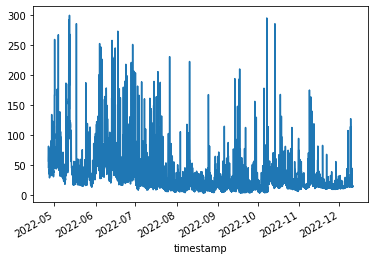

In [4]:
df['average_gas_fee'].plot()

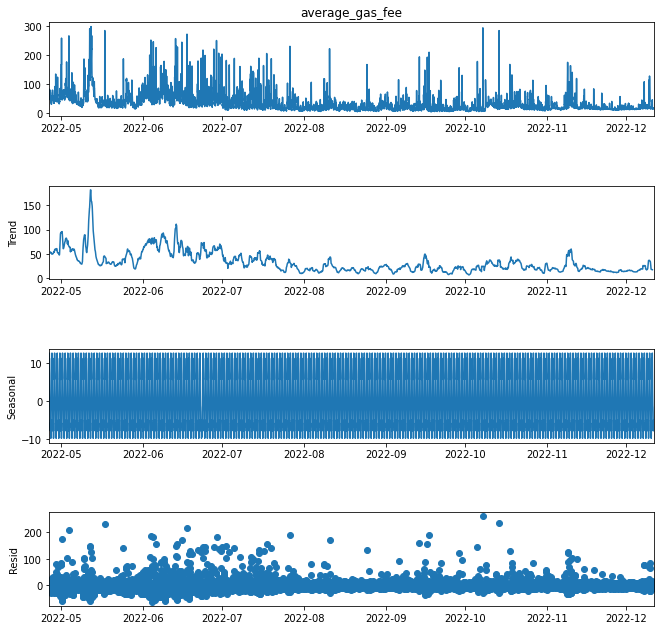

In [5]:
decomposition= sm.tsa.seasonal_decompose(df['average_gas_fee'], model='additive', period= 24 )

ax = decomposition.plot()
ax.set_size_inches(10,10)

plt.show() # It seems data our data has seasonality and it has decreasing trend obviously.

In [6]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

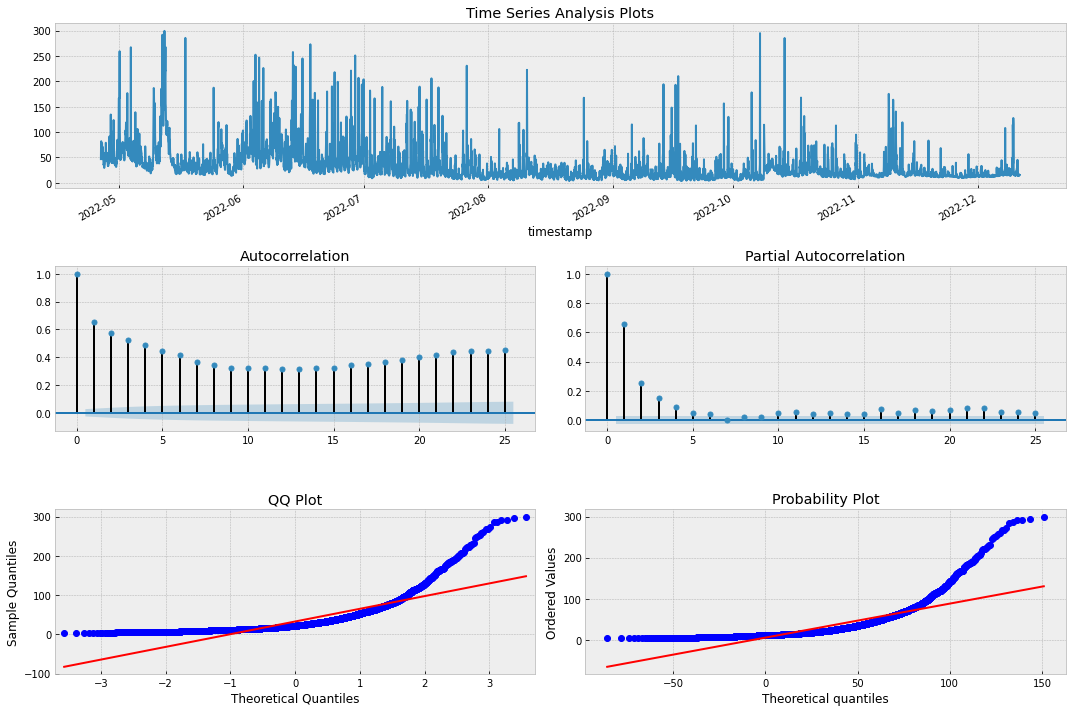

In [7]:
raw_data = tsplot(df['average_gas_fee'], lags=25) 
# The raw data are non-stationary by seeing that they have ACF positive autocorrelation and PACF are gradually decreasing.

In [8]:
# ordinary first differencing
diff_df = df['average_gas_fee'].diff(periods=1).iloc[1:]

# sse logarithim w/ differencing to reduce trend and keep variation width of our data
df_log = np.log(df['average_gas_fee'])
diff_df_log = df_log.diff(periods=1).iloc[1:]

# daily differencing of log differnced data
diff_24_df = diff_df_log.diff(periods=24).iloc[24:]



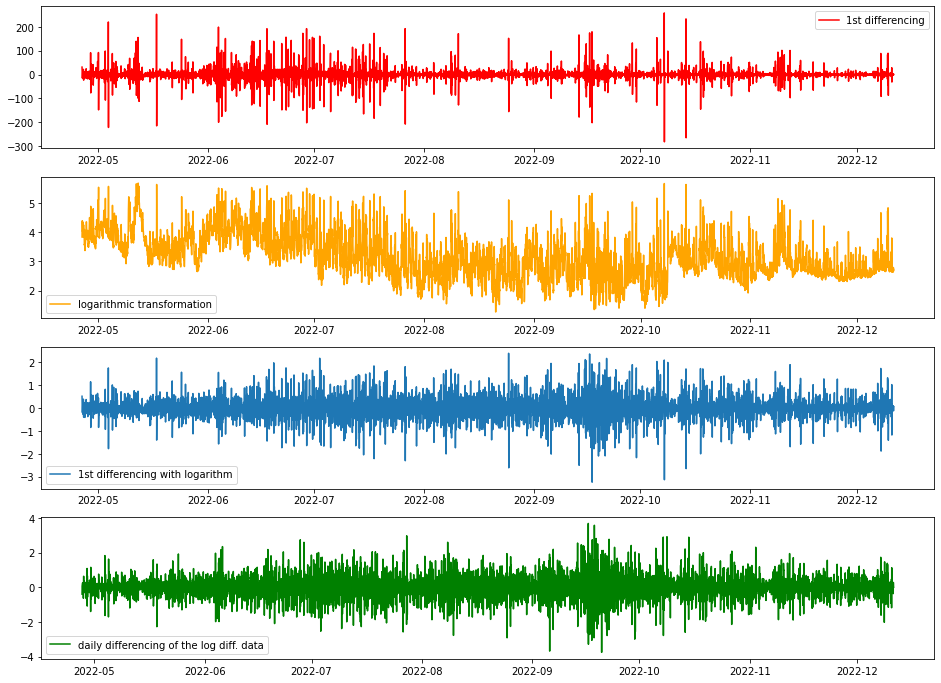

In [12]:
plt.figure(figsize=(16,12))

ax1 = plt.subplot(411)
ax1.plot(diff_df, color='red')
ax1.legend(['1st differencing'])


ax2 = plt.subplot(412)
ax2.plot(df_log, color='orange')
ax2.legend(['logarithmic transformation'])

ax3 = plt.subplot(413)
ax3.plot(diff_df_log)
ax3.legend(['1st differencing with logarithm'])

ax4 = plt.subplot(414)
ax4.plot(diff_24_df, color='green')
ax4.legend(['daily differencing of the log diff. data'], loc = 'lower left')

plt.show()

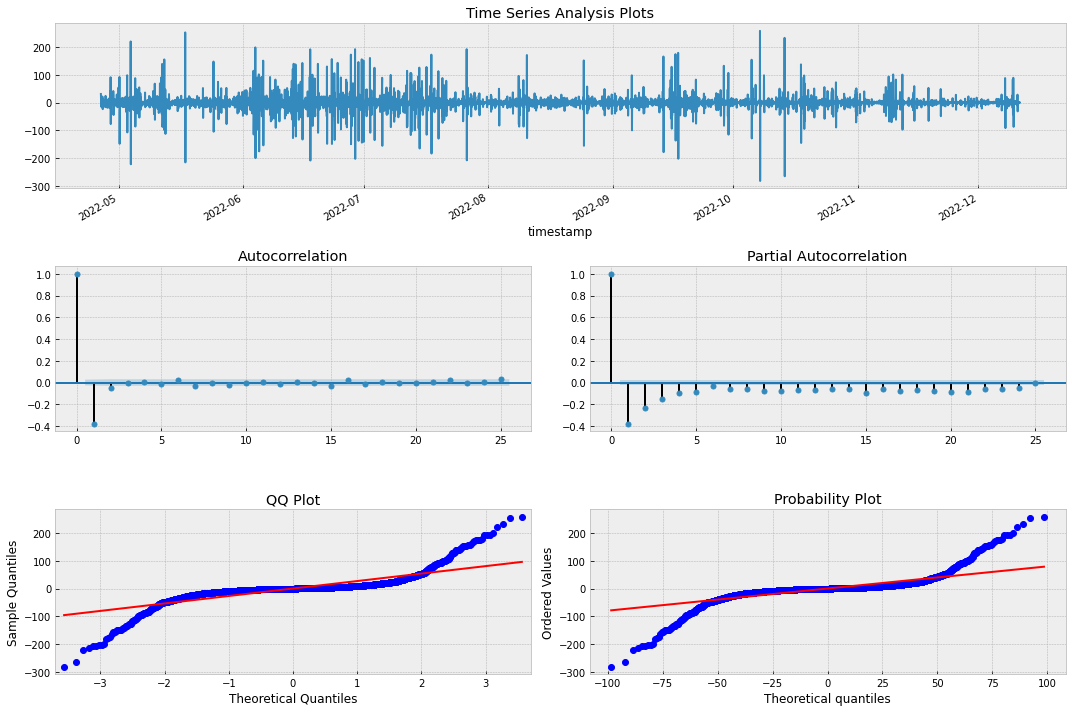

In [13]:
tsplot(diff_df, lags=25)

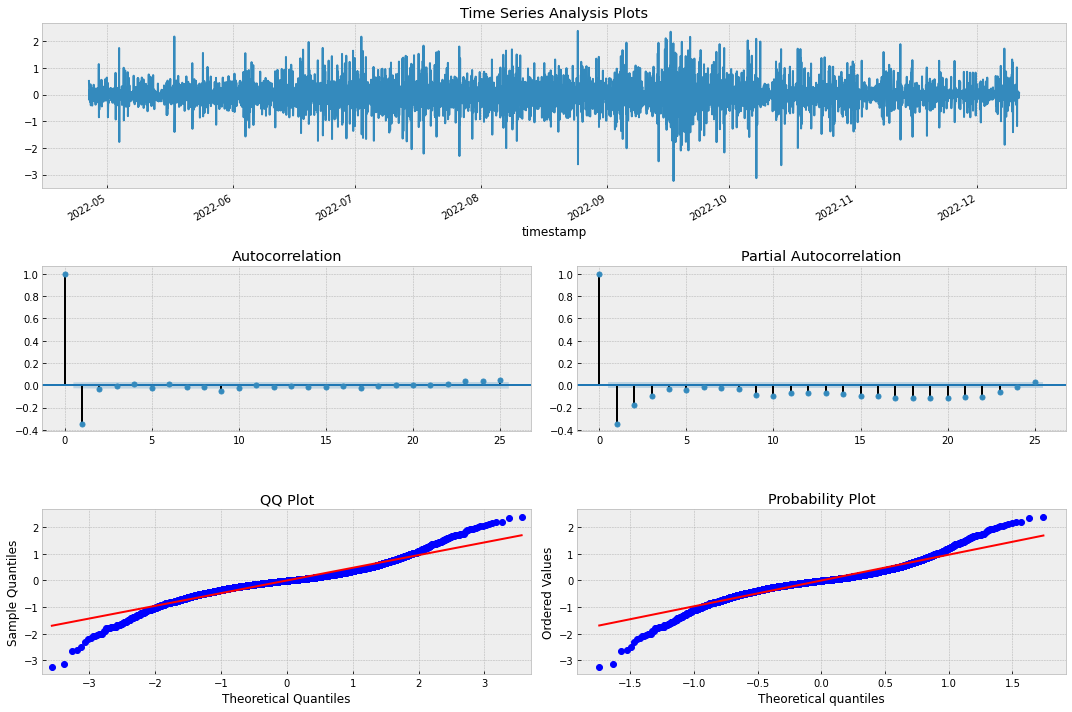

In [14]:
tsplot(diff_df_log, lags=25) # It seems diff_df_log is more stationary according to its ACF

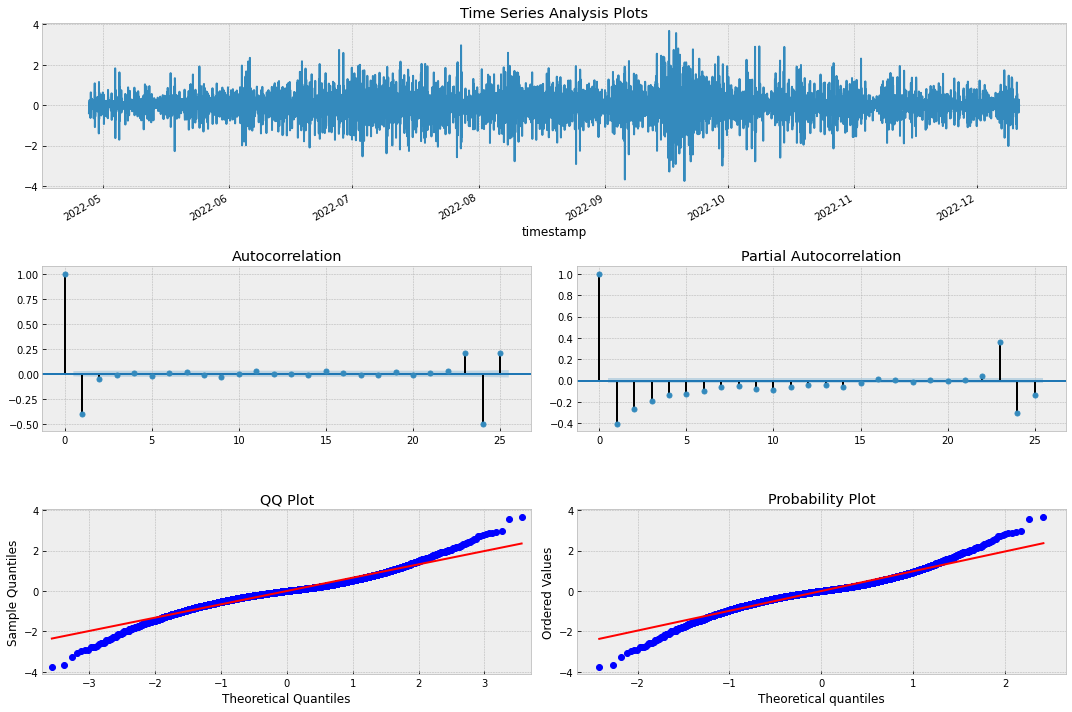

In [17]:
tsplot(diff_24_df, lags=25)

In [16]:
# According to the result of ADF test, it seems that our data is now stationary (for both transformation). (p value is 0)
adf_test = adfuller(diff_df)
adf_test_log = adfuller(diff_df_log)
adf_test_24 = adfuller(diff_24_df)

print('---1st differencing---')
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])


print('---2nd differencing with logarithm---')
print('ADF Statistic: %f' % adf_test_log[0])
print('Critical Values @ 0.05: %.2f' % adf_test_log[4]['5%'])
print('p-value: %20.20f' % adf_test_log[1])

print('---daily differencing of the log-differenced data---')
print('ADF Statistic: %f' % adf_test_24[0])
print('Critical Values @ 0.05: %.2f' % adf_test_24[4]['5%'])
print('p-value: %20.20f' % adf_test_24[1])

---1st differencing---
ADF Statistic: -16.255997
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000
---2nd differencing with logarithm---
ADF Statistic: -15.223578
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000
---daily differencing of the log-differenced data---
ADF Statistic: -19.983066
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000


In [ ]:
# Average gas fee per time
df.groupby(df.index.hour)[['average_gas_fee']].mean()

,average_gas_fee
timestamp,
0,31.566037
1,29.220489
2,28.737703
3,27.746647
4,24.199895
5,22.197776
6,21.726154
7,21.989489
8,23.357426


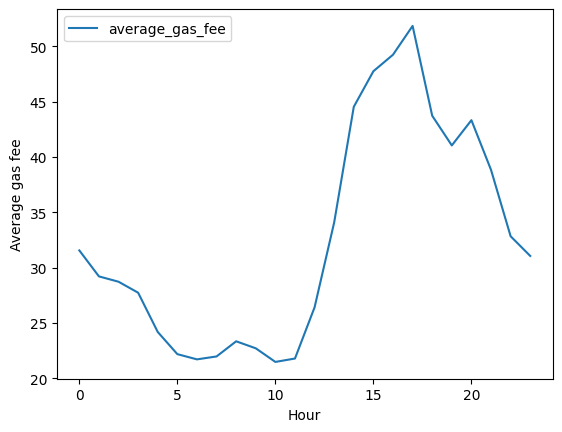

In [ ]:
df.groupby(df.index.hour)[['average_gas_fee']].mean().plot()
plt.xlabel('Hour')
plt.ylabel('Average gas fee')
plt.show()
# Average gas fee is the lowest at 10:00AM and highest at 17:00PM

In [ ]:
df.groupby(df.index.hour)[['average_gas_fee']].mean()[:12].mean() 
# Average gas fee at morning time (00:00 AM - 11:00 AM)

average_gas_fee    24.730373
dtype: float64

In [ ]:
df.groupby(df.index.hour)[['average_gas_fee']].mean()[12:].mean() 
# Average gas fee at afternoon time (12:00 PM - 23:00 PM)
# It clearly seems that the gas fee is higer at the afternoon

average_gas_fee    40.396423
dtype: float64